In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "fsv2"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 296
Categorical features: 5
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 368
Categorical Columns: 5


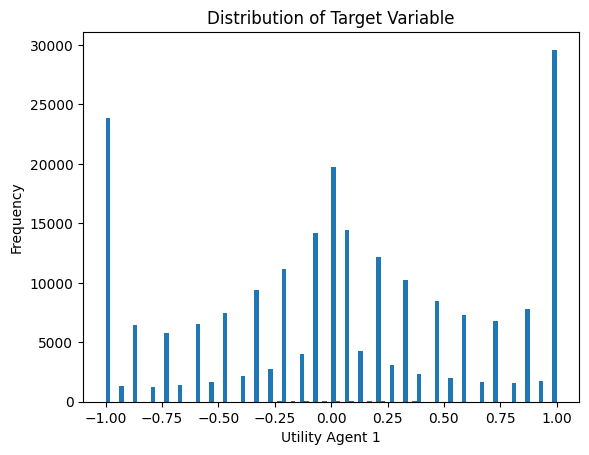

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55305


[100]	val-rmse:0.47254


[200]	val-rmse:0.45376


[300]	val-rmse:0.44481


[400]	val-rmse:0.44027


[500]	val-rmse:0.43714


[600]	val-rmse:0.43511


[700]	val-rmse:0.43374


[800]	val-rmse:0.43265


[900]	val-rmse:0.43182


[1000]	val-rmse:0.43124


[1100]	val-rmse:0.43077


[1200]	val-rmse:0.43052


[1300]	val-rmse:0.43023


[1400]	val-rmse:0.42996


[1500]	val-rmse:0.42994


[1600]	val-rmse:0.42984


[1700]	val-rmse:0.42974


[1800]	val-rmse:0.42984


[1900]	val-rmse:0.42985


[2000]	val-rmse:0.42981


[2100]	val-rmse:0.42965


[2200]	val-rmse:0.42971


[2300]	val-rmse:0.42973


[2400]	val-rmse:0.42968


[2499]	val-rmse:0.42981


Fold 1 - RMSE: 0.42951650854496154
Fold 2


[0]	val-rmse:0.58707


[100]	val-rmse:0.48424


[200]	val-rmse:0.46774


[300]	val-rmse:0.46003


[400]	val-rmse:0.45574


[500]	val-rmse:0.45325


[600]	val-rmse:0.45210


[700]	val-rmse:0.45131


[800]	val-rmse:0.45045


[900]	val-rmse:0.44970


[1000]	val-rmse:0.44919


[1100]	val-rmse:0.44906


[1200]	val-rmse:0.44864


[1300]	val-rmse:0.44815


[1400]	val-rmse:0.44777


[1500]	val-rmse:0.44754


[1600]	val-rmse:0.44737


[1700]	val-rmse:0.44734


[1800]	val-rmse:0.44726


[1900]	val-rmse:0.44709


[2000]	val-rmse:0.44701


[2100]	val-rmse:0.44693


[2200]	val-rmse:0.44692


[2300]	val-rmse:0.44684


[2400]	val-rmse:0.44683


[2499]	val-rmse:0.44678


Fold 2 - RMSE: 0.4463753407303082
Fold 3


[0]	val-rmse:0.60390


[100]	val-rmse:0.48055


[200]	val-rmse:0.45802


[300]	val-rmse:0.44975


[400]	val-rmse:0.44540


[500]	val-rmse:0.44216


[600]	val-rmse:0.44043


[700]	val-rmse:0.43911


[800]	val-rmse:0.43848


[900]	val-rmse:0.43757


[1000]	val-rmse:0.43716


[1100]	val-rmse:0.43690


[1200]	val-rmse:0.43636


[1300]	val-rmse:0.43621


[1400]	val-rmse:0.43584


[1500]	val-rmse:0.43563


[1600]	val-rmse:0.43546


[1700]	val-rmse:0.43530


[1800]	val-rmse:0.43522


[1900]	val-rmse:0.43517


[2000]	val-rmse:0.43517


[2100]	val-rmse:0.43511


[2200]	val-rmse:0.43509


[2300]	val-rmse:0.43494


[2400]	val-rmse:0.43486


[2499]	val-rmse:0.43485


Fold 3 - RMSE: 0.4343933468994739
Fold 4


[0]	val-rmse:0.59427


[100]	val-rmse:0.47931


[200]	val-rmse:0.45996


[300]	val-rmse:0.45092


[400]	val-rmse:0.44599


[500]	val-rmse:0.44285


[600]	val-rmse:0.44067


[700]	val-rmse:0.43948


[800]	val-rmse:0.43830


[900]	val-rmse:0.43772


[1000]	val-rmse:0.43720


[1100]	val-rmse:0.43676


[1200]	val-rmse:0.43624


[1300]	val-rmse:0.43592


[1400]	val-rmse:0.43568


[1500]	val-rmse:0.43538


[1600]	val-rmse:0.43529


[1700]	val-rmse:0.43503


[1800]	val-rmse:0.43490


[1900]	val-rmse:0.43470


[2000]	val-rmse:0.43459


[2100]	val-rmse:0.43452


[2200]	val-rmse:0.43444


[2300]	val-rmse:0.43447


[2400]	val-rmse:0.43442


[2499]	val-rmse:0.43438


Fold 4 - RMSE: 0.43406896099706455
Fold 5


[0]	val-rmse:0.54676


[100]	val-rmse:0.45010


[200]	val-rmse:0.42840


[300]	val-rmse:0.41822


[400]	val-rmse:0.41321


[500]	val-rmse:0.41002


[600]	val-rmse:0.40789


[700]	val-rmse:0.40609


[800]	val-rmse:0.40469


[900]	val-rmse:0.40400


[1000]	val-rmse:0.40339


[1100]	val-rmse:0.40304


[1200]	val-rmse:0.40252


[1300]	val-rmse:0.40217


[1400]	val-rmse:0.40186


[1500]	val-rmse:0.40157


[1600]	val-rmse:0.40146


[1700]	val-rmse:0.40142


[1800]	val-rmse:0.40139


[1900]	val-rmse:0.40127


[2000]	val-rmse:0.40130


[2100]	val-rmse:0.40127


[2200]	val-rmse:0.40117


[2300]	val-rmse:0.40121


[2400]	val-rmse:0.40118


[2499]	val-rmse:0.40119


Fold 5 - RMSE: 0.4008931753635581
List of oof scores: [0.42951650854496154, 0.4463753407303082, 0.4343933468994739, 0.43406896099706455, 0.4008931753635581]
Average oof score: 0.42904946650707326


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53410


[100]	val-rmse:0.45132


[200]	val-rmse:0.43375


[300]	val-rmse:0.42669


[400]	val-rmse:0.42294


[500]	val-rmse:0.42065


[600]	val-rmse:0.41905


[700]	val-rmse:0.41807


[800]	val-rmse:0.41733


[900]	val-rmse:0.41616


[1000]	val-rmse:0.41576


[1100]	val-rmse:0.41531


[1200]	val-rmse:0.41513


[1300]	val-rmse:0.41476


[1400]	val-rmse:0.41473


[1500]	val-rmse:0.41447


[1600]	val-rmse:0.41429


[1700]	val-rmse:0.41407


[1800]	val-rmse:0.41413


[1900]	val-rmse:0.41396


[2000]	val-rmse:0.41387


[2100]	val-rmse:0.41372


[2200]	val-rmse:0.41373


[2300]	val-rmse:0.41367


[2400]	val-rmse:0.41354


[2499]	val-rmse:0.41351


Fold 1 - RMSE: 0.4132553338145309
Fold 2


[0]	val-rmse:0.54421


[100]	val-rmse:0.43504


[200]	val-rmse:0.42000


[300]	val-rmse:0.41440


[400]	val-rmse:0.41124


[500]	val-rmse:0.40935


[600]	val-rmse:0.40841


[700]	val-rmse:0.40742


[800]	val-rmse:0.40688


[900]	val-rmse:0.40640


[1000]	val-rmse:0.40623


[1100]	val-rmse:0.40616


[1200]	val-rmse:0.40599


[1300]	val-rmse:0.40577


[1400]	val-rmse:0.40578


[1500]	val-rmse:0.40575


[1600]	val-rmse:0.40570


[1700]	val-rmse:0.40576


[1800]	val-rmse:0.40576


[1900]	val-rmse:0.40589


[2000]	val-rmse:0.40583


[2100]	val-rmse:0.40599


[2200]	val-rmse:0.40605


[2300]	val-rmse:0.40609


[2400]	val-rmse:0.40612


[2499]	val-rmse:0.40625


Fold 2 - RMSE: 0.40581471625702886
Fold 3


[0]	val-rmse:0.61203


[100]	val-rmse:0.48909


[200]	val-rmse:0.46428


[300]	val-rmse:0.45212


[400]	val-rmse:0.44631


[500]	val-rmse:0.44255


[600]	val-rmse:0.43995


[700]	val-rmse:0.43814


[800]	val-rmse:0.43673


[900]	val-rmse:0.43580


[1000]	val-rmse:0.43488


[1100]	val-rmse:0.43433


[1200]	val-rmse:0.43379


[1300]	val-rmse:0.43340


[1400]	val-rmse:0.43303


[1500]	val-rmse:0.43262


[1600]	val-rmse:0.43236


[1700]	val-rmse:0.43224


[1800]	val-rmse:0.43208


[1900]	val-rmse:0.43191


[2000]	val-rmse:0.43174


[2100]	val-rmse:0.43157


[2200]	val-rmse:0.43143


[2300]	val-rmse:0.43131


[2400]	val-rmse:0.43119


[2499]	val-rmse:0.43100


Fold 3 - RMSE: 0.43057071401221153
Fold 4


[0]	val-rmse:0.60415


[100]	val-rmse:0.48993


[200]	val-rmse:0.46711


[300]	val-rmse:0.45730


[400]	val-rmse:0.45228


[500]	val-rmse:0.44924


[600]	val-rmse:0.44708


[700]	val-rmse:0.44560


[800]	val-rmse:0.44454


[900]	val-rmse:0.44386


[1000]	val-rmse:0.44312


[1100]	val-rmse:0.44227


[1200]	val-rmse:0.44194


[1300]	val-rmse:0.44179


[1400]	val-rmse:0.44175


[1500]	val-rmse:0.44150


[1600]	val-rmse:0.44121


[1700]	val-rmse:0.44102


[1800]	val-rmse:0.44104


[1900]	val-rmse:0.44084


[2000]	val-rmse:0.44075


[2100]	val-rmse:0.44065


[2200]	val-rmse:0.44076


[2300]	val-rmse:0.44078


[2400]	val-rmse:0.44078


[2499]	val-rmse:0.44067


Fold 4 - RMSE: 0.4403184322926865
Fold 5


[0]	val-rmse:0.58982


[100]	val-rmse:0.49127


[200]	val-rmse:0.46748


[300]	val-rmse:0.45665


[400]	val-rmse:0.45133


[500]	val-rmse:0.44741


[600]	val-rmse:0.44543


[700]	val-rmse:0.44405


[800]	val-rmse:0.44291


[900]	val-rmse:0.44215


[1000]	val-rmse:0.44124


[1100]	val-rmse:0.44082


[1200]	val-rmse:0.44043


[1300]	val-rmse:0.44022


[1400]	val-rmse:0.43990


[1500]	val-rmse:0.43965


[1600]	val-rmse:0.43964


[1700]	val-rmse:0.43945


[1800]	val-rmse:0.43951


[1900]	val-rmse:0.43940


[2000]	val-rmse:0.43928


[2100]	val-rmse:0.43907


[2200]	val-rmse:0.43892


[2300]	val-rmse:0.43883


[2400]	val-rmse:0.43883


[2499]	val-rmse:0.43886


Fold 5 - RMSE: 0.4384785547724228
List of oof scores: [0.4132553338145309, 0.40581471625702886, 0.43057071401221153, 0.4403184322926865, 0.4384785547724228]
Average oof score: 0.42568755022977617


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57470


[100]	val-rmse:0.48033


[200]	val-rmse:0.46218


[300]	val-rmse:0.45452


[400]	val-rmse:0.45007


[500]	val-rmse:0.44765


[600]	val-rmse:0.44578


[700]	val-rmse:0.44464


[800]	val-rmse:0.44373


[900]	val-rmse:0.44294


[1000]	val-rmse:0.44250


[1100]	val-rmse:0.44213


[1200]	val-rmse:0.44185


[1300]	val-rmse:0.44155


[1400]	val-rmse:0.44135


[1500]	val-rmse:0.44128


[1600]	val-rmse:0.44120


[1700]	val-rmse:0.44106


[1800]	val-rmse:0.44108


[1900]	val-rmse:0.44104


[2000]	val-rmse:0.44106


[2100]	val-rmse:0.44105


[2200]	val-rmse:0.44105


[2300]	val-rmse:0.44107


[2400]	val-rmse:0.44101


[2499]	val-rmse:0.44095


Fold 1 - RMSE: 0.4405546850027622
Fold 2


[0]	val-rmse:0.57275


[100]	val-rmse:0.47405


[200]	val-rmse:0.45138


[300]	val-rmse:0.44045


[400]	val-rmse:0.43484


[500]	val-rmse:0.43065


[600]	val-rmse:0.42816


[700]	val-rmse:0.42633


[800]	val-rmse:0.42522


[900]	val-rmse:0.42390


[1000]	val-rmse:0.42294


[1100]	val-rmse:0.42210


[1200]	val-rmse:0.42138


[1300]	val-rmse:0.42081


[1400]	val-rmse:0.42036


[1500]	val-rmse:0.42017


[1600]	val-rmse:0.41988


[1700]	val-rmse:0.41972


[1800]	val-rmse:0.41949


[1900]	val-rmse:0.41928


[2000]	val-rmse:0.41922


[2100]	val-rmse:0.41918


[2200]	val-rmse:0.41908


[2300]	val-rmse:0.41901


[2400]	val-rmse:0.41891


[2499]	val-rmse:0.41899


Fold 2 - RMSE: 0.41866888101747335
Fold 3


[0]	val-rmse:0.57576


[100]	val-rmse:0.47413


[200]	val-rmse:0.45645


[300]	val-rmse:0.44879


[400]	val-rmse:0.44548


[500]	val-rmse:0.44356


[600]	val-rmse:0.44219


[700]	val-rmse:0.44078


[800]	val-rmse:0.43989


[900]	val-rmse:0.43927


[1000]	val-rmse:0.43904


[1100]	val-rmse:0.43877


[1200]	val-rmse:0.43838


[1300]	val-rmse:0.43789


[1400]	val-rmse:0.43792


[1500]	val-rmse:0.43777


[1600]	val-rmse:0.43784


[1700]	val-rmse:0.43771


[1800]	val-rmse:0.43768


[1900]	val-rmse:0.43781


[2000]	val-rmse:0.43783


[2100]	val-rmse:0.43781


[2200]	val-rmse:0.43769


[2300]	val-rmse:0.43779


[2400]	val-rmse:0.43772


[2499]	val-rmse:0.43768


Fold 3 - RMSE: 0.4373242377675932
Fold 4


[0]	val-rmse:0.57308


[100]	val-rmse:0.46538


[200]	val-rmse:0.44671


[300]	val-rmse:0.43854


[400]	val-rmse:0.43399


[500]	val-rmse:0.43090


[600]	val-rmse:0.42904


[700]	val-rmse:0.42781


[800]	val-rmse:0.42718


[900]	val-rmse:0.42641


[1000]	val-rmse:0.42575


[1100]	val-rmse:0.42535


[1200]	val-rmse:0.42501


[1300]	val-rmse:0.42461


[1400]	val-rmse:0.42431


[1500]	val-rmse:0.42408


[1600]	val-rmse:0.42398


[1700]	val-rmse:0.42389


[1800]	val-rmse:0.42387


[1900]	val-rmse:0.42367


[2000]	val-rmse:0.42364


[2100]	val-rmse:0.42365


[2200]	val-rmse:0.42358


[2300]	val-rmse:0.42355


[2400]	val-rmse:0.42358


[2499]	val-rmse:0.42348


Fold 4 - RMSE: 0.423170364947682
Fold 5


[0]	val-rmse:0.58422


[100]	val-rmse:0.47598


[200]	val-rmse:0.45469


[300]	val-rmse:0.44354


[400]	val-rmse:0.43800


[500]	val-rmse:0.43454


[600]	val-rmse:0.43224


[700]	val-rmse:0.43011


[800]	val-rmse:0.42903


[900]	val-rmse:0.42810


[1000]	val-rmse:0.42707


[1100]	val-rmse:0.42646


[1200]	val-rmse:0.42608


[1300]	val-rmse:0.42570


[1400]	val-rmse:0.42522


[1500]	val-rmse:0.42497


[1600]	val-rmse:0.42480


[1700]	val-rmse:0.42470


[1800]	val-rmse:0.42454


[1900]	val-rmse:0.42454


[2000]	val-rmse:0.42447


[2100]	val-rmse:0.42421


[2200]	val-rmse:0.42409


[2300]	val-rmse:0.42402


[2400]	val-rmse:0.42391


[2499]	val-rmse:0.42395


Fold 5 - RMSE: 0.423659127108537
List of oof scores: [0.4405546850027622, 0.41866888101747335, 0.4373242377675932, 0.423170364947682, 0.423659127108537]
Average oof score: 0.4286754591688095


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4295
Score: 0.4464
Score: 0.4344
Score: 0.4341
Score: 0.4009
Average CV1 Score: 0.4290

CV2 OOF Scores:
Score: 0.4133
Score: 0.4058
Score: 0.4306
Score: 0.4403
Score: 0.4385
Average CV2 Score: 0.4257

CV3 OOF Scores:
Score: 0.4406
Score: 0.4187
Score: 0.4373
Score: 0.4232
Score: 0.4237
Average CV3 Score: 0.4287


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

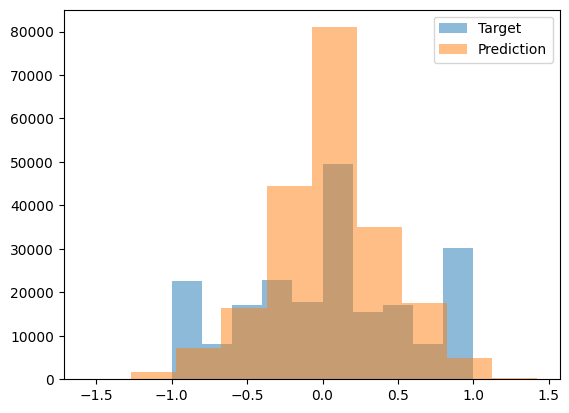

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***